In [39]:
import random
import joblib
import warnings
import os

import numpy as np 
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import gudhi
import persim
from ripser import ripser
from persim import PersistenceImager

%matplotlib inline
pimager = PersistenceImager(pixel_size=0.2)
warnings.filterwarnings("ignore", category=RuntimeWarning)
mpl.rcParams['text.usetex'] = False

np.random.seed(42)
random.seed(42)

print("GUDHI:",gudhi.__version__)
print("persim:",persim.__version__)

GUDHI: 3.11.0
persim: 0.3.8


### 🔹 Load and Inspect the Dataset

We begin by loading the *Epileptic Seizure Recognition* dataset. The target variable is `y`, which indicates the class of EEG signal recorded. The dataset contains time-series measurements for different brain states. The class labels are as follows:

- `1`: Seizure activity  
- `2`: EEG recording from the tumor area  
- `3`: EEG recording from a region where a tumor was identified  
- `4`: EEG recording with eyes closed  
- `5`: EEG recording with eyes open  

We exclude the ID column (typically the first column) and isolate the predictor variables. The goal is to use these features to classify brain activity using topological and classical signal analysis methods.


In [40]:
data = pd.read_csv("Epileptic Seizure Recognition.csv")

target = 'y'
predictors = data.columns.to_list()[1:]
predictors.remove(target)
print(data.head())
class_labels = {
    5: 'eyes open',
    4: 'eyes closed',
    3: 'tumor region identified',
    2: 'EEG from tumor area',
    1: 'seizure activity'
}

      Unnamed   X1   X2   X3   X4   X5   X6   X7   X8   X9  ...  X170  X171  \
0  X21.V1.791  135  190  229  223  192  125   55   -9  -33  ...   -17   -15   
1  X15.V1.924  386  382  356  331  320  315  307  272  244  ...   164   150   
2     X8.V1.1  -32  -39  -47  -37  -32  -36  -57  -73  -85  ...    57    64   
3   X16.V1.60 -105 -101  -96  -92  -89  -95 -102 -100  -87  ...   -82   -81   
4   X20.V1.54   -9  -65  -98 -102  -78  -48  -16    0  -21  ...     4     2   

   X172  X173  X174  X175  X176  X177  X178  y  
0   -31   -77  -103  -127  -116   -83   -51  4  
1   146   152   157   156   154   143   129  1  
2    48    19   -12   -30   -35   -35   -36  5  
3   -80   -77   -85   -77   -72   -69   -65  5  
4   -12   -32   -41   -65   -83   -89   -73  5  

[5 rows x 180 columns]


### 🔹 Feature Extraction and Normalization

- `get_features_and_labels(data, scale=True)`:  
  Extracts labels (`y`) and features (`X`) from the dataset. If `scale=True`, applies `StandardScaler` to normalize the features.

- `normalize_data(df, predictors)`:  
  Applies Min-Max normalization to the selected predictor columns, scaling each to the [0, 1] range.


In [41]:
def get_features_and_labels(data, scale=True):
    y = data['y']
    X = data[[x for x in data.columns if x.startswith('X')]]
    if scale == True:
        scaler = StandardScaler() # Try min-max scaler
        X = scaler.fit_transform(X)
    return y, X

def normalize_data(df, predictors):
    X_normalized = pd.DataFrame(
        MinMaxScaler().fit_transform(df[predictors].T).T,
        columns=predictors,
        index=df.index
    )
    return X_normalized

### 🔹 Visualizing the Data

- `plot_class_signals(X, y, samples=5)`:  
  Plots example signal traces for each class to visualize differences in EEG patterns.

- `plot_class_distribution(df, label_column='y')`:  
  Displays a pie chart showing the proportion of each class in the dataset.


In [42]:
def plot_class_signals(X, y, samples=5):
    fig, axes = plt.subplots(samples, 5, figsize=(15, 10))

    label_colors = {
        1: ('Seizure activity', 'blue'),
        2: ('Tumor area', 'green'),
        3: ('Tumor region', 'red'),
        4: ('Eyes closed', 'orange'),
        5: ('Eyes open', 'purple')
    }

    for i in range(samples):
        for col, (label, color) in label_colors.items():
            subset = X[y == col]
            axes[i, col - 1].plot(subset.iloc[i].values, color=color)
            axes[i, col - 1].set_title(f"{col}: {label}")

    plt.tight_layout()
    plt.show()


def plot_class_distribution(df, label_column='y'):
    value_counts = df[label_column].value_counts()

    custom_colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']

    plt.figure(figsize=(10, 6))
    plt.pie(
        value_counts,
        labels=value_counts.index,
        autopct='%1.1f%%',
        startangle=140,
        wedgeprops={'edgecolor': 'black'},
        pctdistance=0.8,
        colors=custom_colors,
    )
    plt.title('Class Distribution')
    plt.axis('equal')  # Equal aspect ratio ensures the pie is circular
    plt.show()

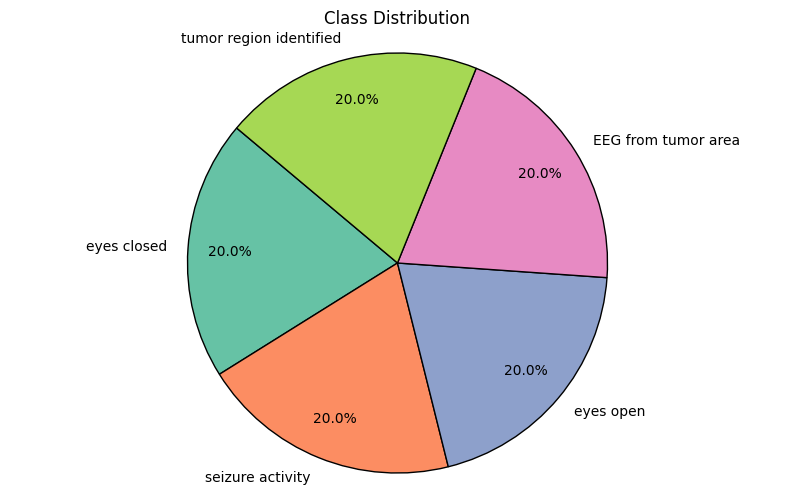

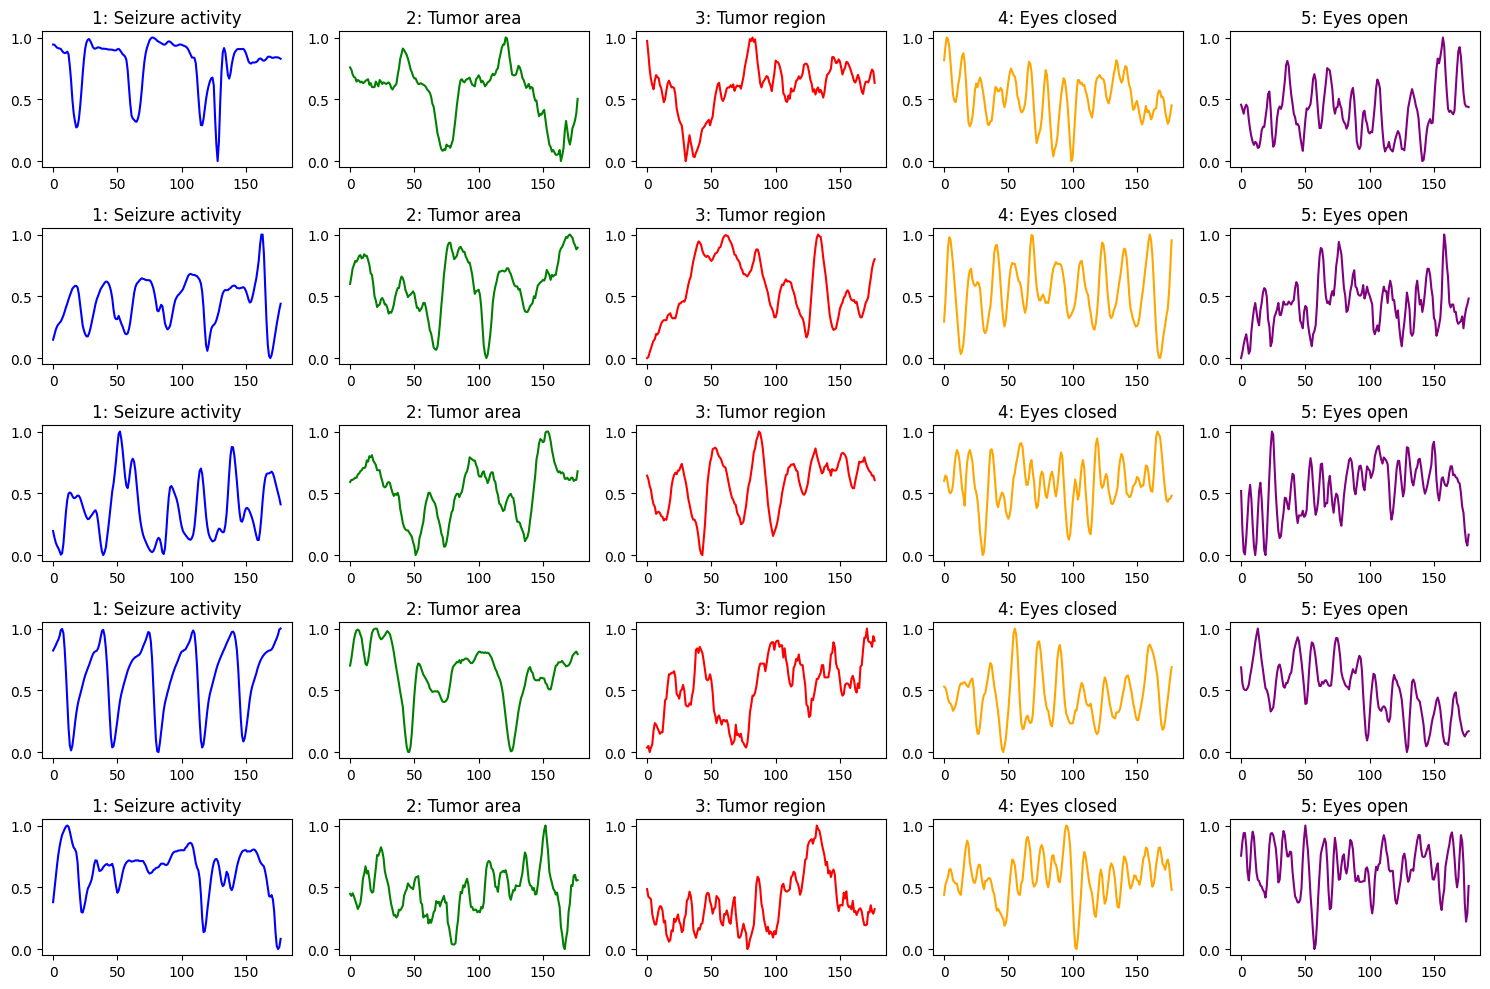

In [43]:
df_viz = data.copy()
df_viz['y'] = df_viz['y'].map(class_labels)
X_viz = normalize_data(df_viz, predictors)  
y_viz, _ =  get_features_and_labels(data) 
 
plot_class_distribution(df_viz)
plot_class_signals(X_viz, y_viz)

### 🔹 Persistence Image & Diagram Visualization

- `plot_persistence_images(labels, persistence_images, ...)`:  
  Displays sample persistence images for each class and optionally saves the plot.

- `plot_persistence_diagrams_from_data(dataframe_, name, ...)`:  
  Computes and plots persistence diagrams (H0 and H1) per class from raw data, with PCA preprocessing, and optionally saves the figures.


In [44]:
def plot_persistence_images(labels, persistence_images, name, samples_per_class=3, save=True):
    os.makedirs("images", exist_ok=True)
    unique_labels = np.unique(labels)
    
    n_classes = len(unique_labels)
    fig = plt.figure(figsize=(4*n_classes, 3*samples_per_class))
    
    for class_idx, label in enumerate(unique_labels):
        class_indices = np.where(labels == label)[0]
        
        if len(class_indices) > samples_per_class:
            selected_indices = np.random.choice(class_indices, samples_per_class, replace=False)
        else:
            selected_indices = class_indices
        
        for sample_idx, idx in enumerate(selected_indices):
            ax = plt.subplot(samples_per_class, n_classes, class_idx + sample_idx*n_classes + 1)
            im = ax.imshow(persistence_images[idx], origin='lower', cmap='jet')
            
            if sample_idx == 0:
                ax.set_title(f'Class {label}')
            ax.axis('off')
    
    plt.suptitle(f"Persistence Images for the {name.replace('_', ' ').title()}")
    plt.tight_layout()
    
    if save:
        plt.savefig(f"images/persistence_images_{name}.png", bbox_inches='tight', dpi=300)
    plt.show()


def plot_persistence_diagrams_from_data(dataframe_, name, save=True):
    ids = dataframe_['Unnamed']
    dataframe_['subject_ids'] = ids.str.extract(r'(\d+$)')[0].astype(int)
    subject_ids = dataframe_['subject_ids'].values
    
    y, X = get_features_and_labels(dataframe_)
    pca = PCA(n_components=2)
    X_pca = pca.fit(X).transform(X)
    
    diagrams = {'H0': [], 'H1': []}
    labels = []

    unique_subjects = np.unique(subject_ids)
    
    for subject in unique_subjects:
        subject_mask = (subject_ids == subject)
        X_subject_pca = X_pca[subject_mask]
        
        ph_result = ripser(X_subject_pca, maxdim=1)
        diagrams['H1'].append(ph_result['dgms'][1])  
        diagrams['H0'].append(ph_result['dgms'][0])  
        
        subject_labels = y[subject_mask]
        if len(subject_labels) > 0:
            if hasattr(subject_labels, "iloc"):
                labels.append(subject_labels.iloc[0])
            else:
                labels.append(subject_labels[0])
        else:
            labels.append(None)
    
    labels = np.array(labels)
    
    os.makedirs("images", exist_ok=True)
    unique_labels = np.unique(labels)
    samples_per_class = 1
    
    n_classes = len(unique_labels)
    fig = plt.figure(figsize=(4*n_classes, 3*samples_per_class))
    
    for class_idx, label in enumerate(unique_labels):
        class_indices = np.where(labels == label)[0]
        
        if len(class_indices) > samples_per_class:
            selected_indices = np.random.choice(class_indices, samples_per_class, replace=False)
        else:
            selected_indices = class_indices
        
        for sample_idx, idx in enumerate(selected_indices):
            ax = plt.subplot(samples_per_class, n_classes, class_idx + sample_idx*n_classes + 1)
    
            dgm = diagrams['H1'][idx]
            
            if len(dgm) > 0:
                ax.scatter(dgm[:, 0], dgm[:, 1], label='H1', alpha=0.6)
                
                min_birth = np.min(dgm[:, 0])
                max_death = np.max(dgm[:, 1])
                diagonal = np.linspace(min_birth, max_death, 2)
                ax.plot(diagonal, diagonal, 'k--', alpha=0.5)
            
            if sample_idx == 0:
                ax.set_title(f'Class {label}')
                ax.legend()
            
            ax.set_xlabel('Birth' if sample_idx == samples_per_class-1 else '')
            ax.set_ylabel('Death' if class_idx == 0 else '')
            ax.grid(True, alpha=0.3)
    
    plt.suptitle(f"Persistence Diagrams for the {name.replace('_', ' ').title()}")
    plt.tight_layout()
    
    if save:
        plt.savefig(f"images/persistence_diagrams_{name}.png", bbox_inches='tight', dpi=300)
    plt.show()

### `get_tda_features_and_labels(dataframe_)`

Extracts persistence images and labels from a dataset using Topological Data Analysis (TDA).

- **Process:**
  - Parses subject and time identifiers from the data.
  - Applies PCA to reduce feature dimensions.
  - Computes persistence diagrams (dimension 1) with Ripser on each subject's PCA-transformed data.
  - Converts persistence diagrams into persistence images.
  - Collects corresponding labels per subject.

- **Inputs:**
  - `dataframe_`: Pandas DataFrame containing raw data with an ID column and features.

- **Outputs:**
  - `labels`: Array of subject labels.
  - `persistence_images`: Array of persistence images representing topological features per subject.


In [45]:
def get_tda_features_and_labels(dataframe_):
    """
    Generates persistence images and corresponding labels from the input DataFrame using TDA.

    Extracts subject and second IDs from a column, applies PCA on features, computes persistence
    diagrams via ripser for each subject's PCA-reduced data, transforms them into persistence images,
    and collects the associated labels.

    Args:
        dataframe_ (DataFrame): Input data containing 'Unnamed' ID column and features.

    Returns:
        tuple: (labels, persistence_images) where labels is an array of subject labels and
            persistence_images is an array of TDA persistence images for each subject.
    """

    ids = dataframe_['Unnamed']
    dataframe_['second_ids'] = ids.str.extract(r'(\d+)')[0].astype(int)
    dataframe_['subject_ids'] = ids.str.extract(r'(\d+$)')[0].astype(int)
    subjects_data = dataframe_.sort_values('subject_ids')
    seconds_data = dataframe_.sort_values('second_ids')

    subject_ids = dataframe_['subject_ids'].values 
    unique_subjects = np.unique(subject_ids) #

    pim = PersistenceImager(birth_range=(0, 5), pers_range=(0, 5), pixel_size=0.5)

    persistence_images = []
    labels = []

    y, X = get_features_and_labels(dataframe_)

    pca = PCA(n_components=2)
    X_pca = pca.fit(X).transform(X)

    for index, subject in enumerate(subject_ids):
        subject_mask = (subject_ids == subject)
        X_subject_pca = X_pca[subject_mask]

        ph_result = ripser(X_subject_pca, maxdim=1)
        pd_ = ph_result['dgms'][1]
        pd_clipped = np.clip(pd_, a_min=(0, 0), a_max=(5,5))
        
        if len(pd_clipped) > 0:
            pim_result = pim.transform(pd_clipped)
        else:
            pim_result = np.zeros((int((5-0)/0.5), int((5-0)/0.5)))

        persistence_images.append(pim_result)

        subject_labels = y[subject_mask]
        if len(subject_labels) > 0:
            if hasattr(subject_labels, "iloc"):
                labels.append(subject_labels.iloc[0])
            else:
                labels.append(subject_labels[0])
        else:
            labels.append(None)
        
    persistence_images = np.array(persistence_images)
    labels = np.array(labels)
    
    return labels, persistence_images


/var/folders/xy/03cjwd9527j8gnxjzhw31yjm0000gn/T/ipykernel_84535/1549172904.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_['second_ids'] = ids.str.extract(r'(\d+)')[0].astype(int)
/var/folders/xy/03cjwd9527j8gnxjzhw31yjm0000gn/T/ipykernel_84535/1549172904.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_['subject_ids'] = ids.str.extract(r'(\d+$)')[0].astype(int)


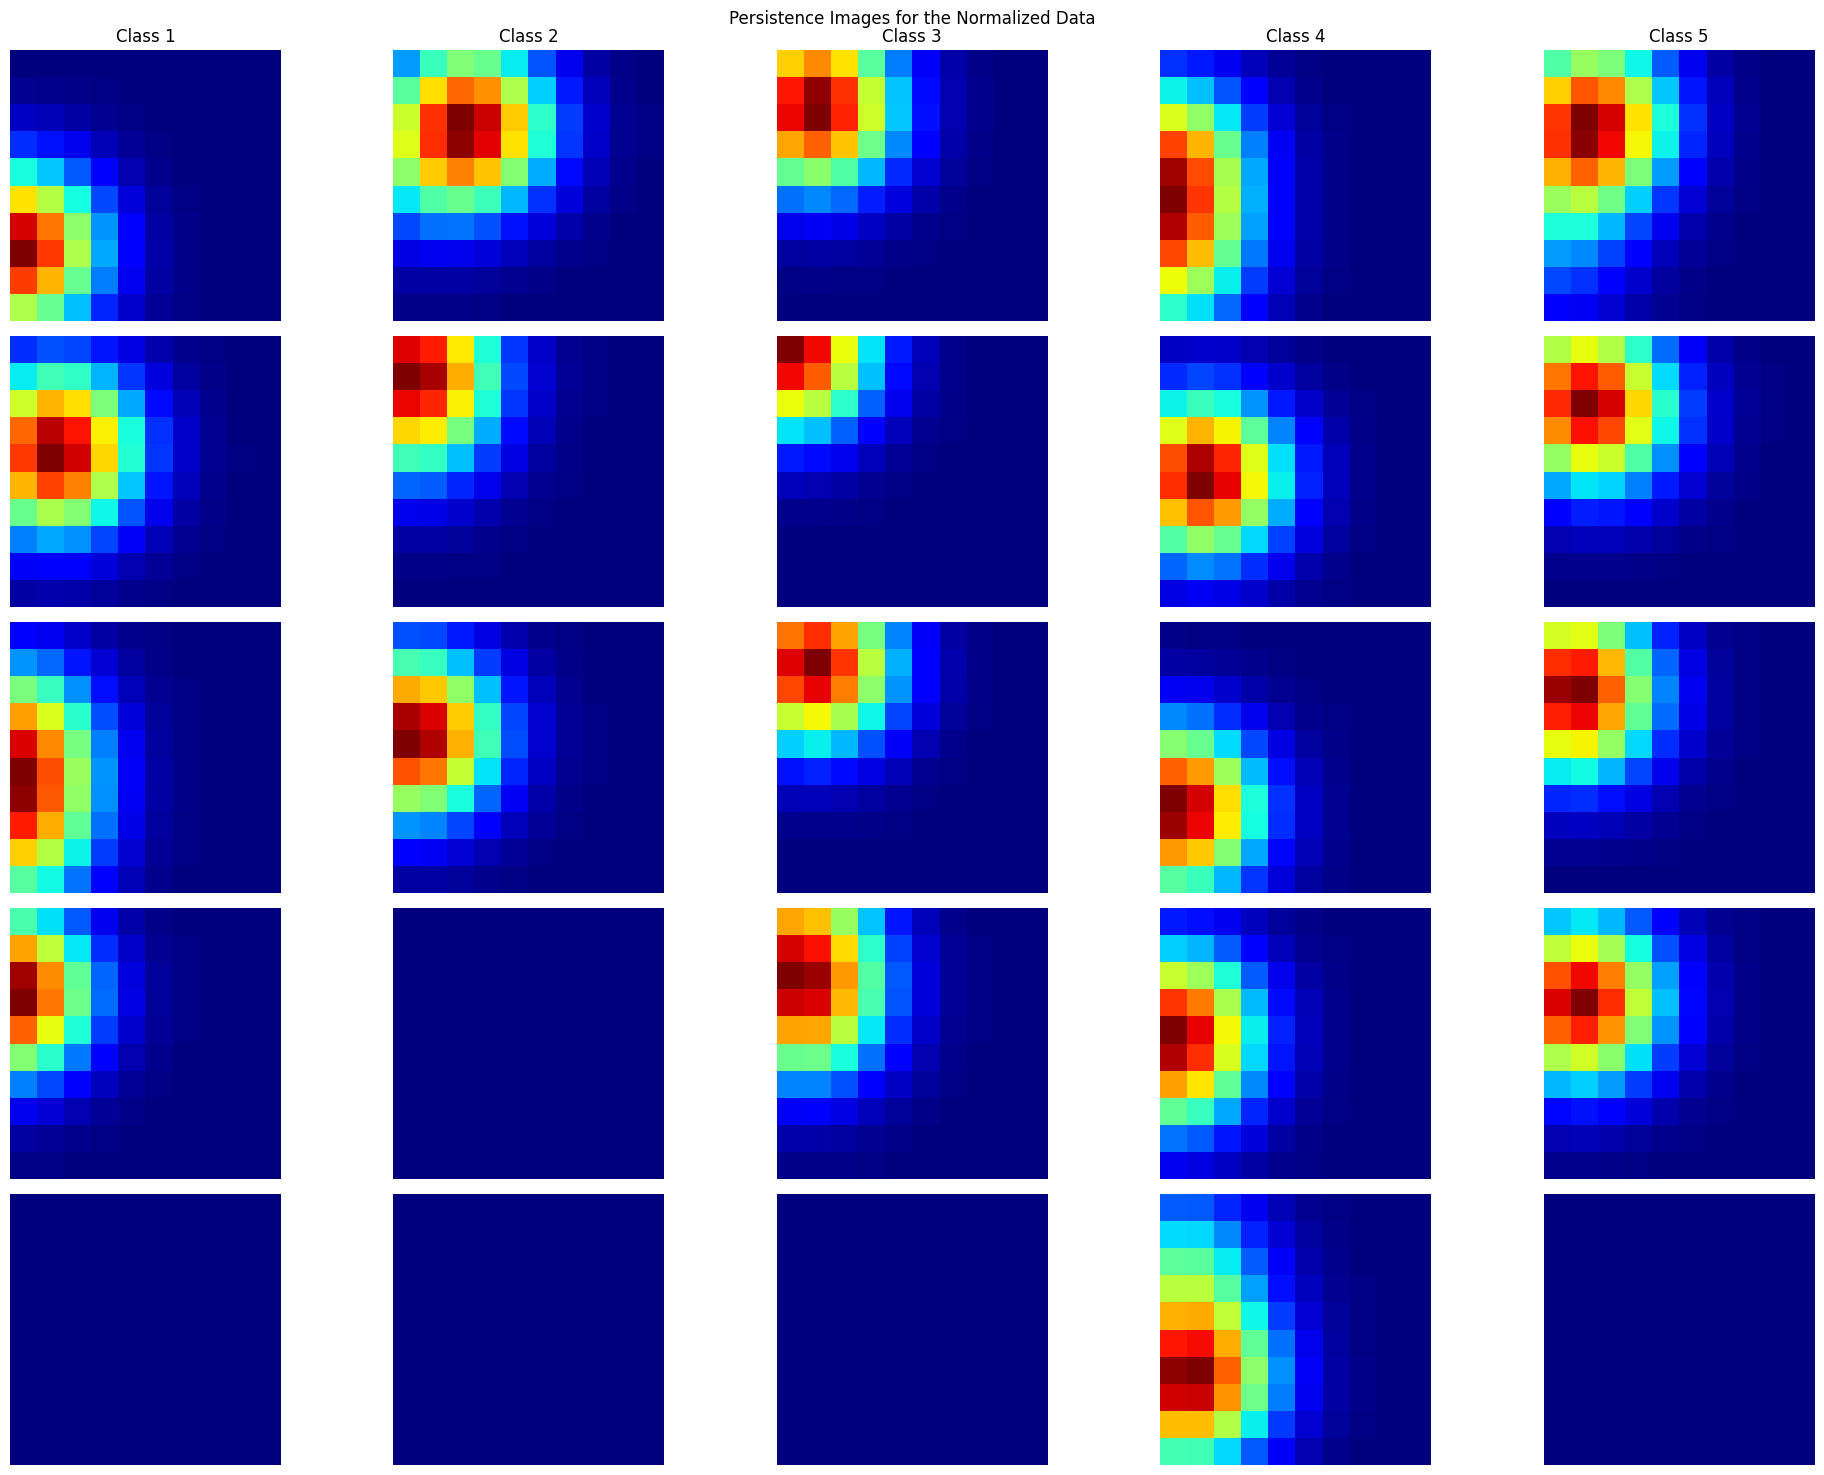

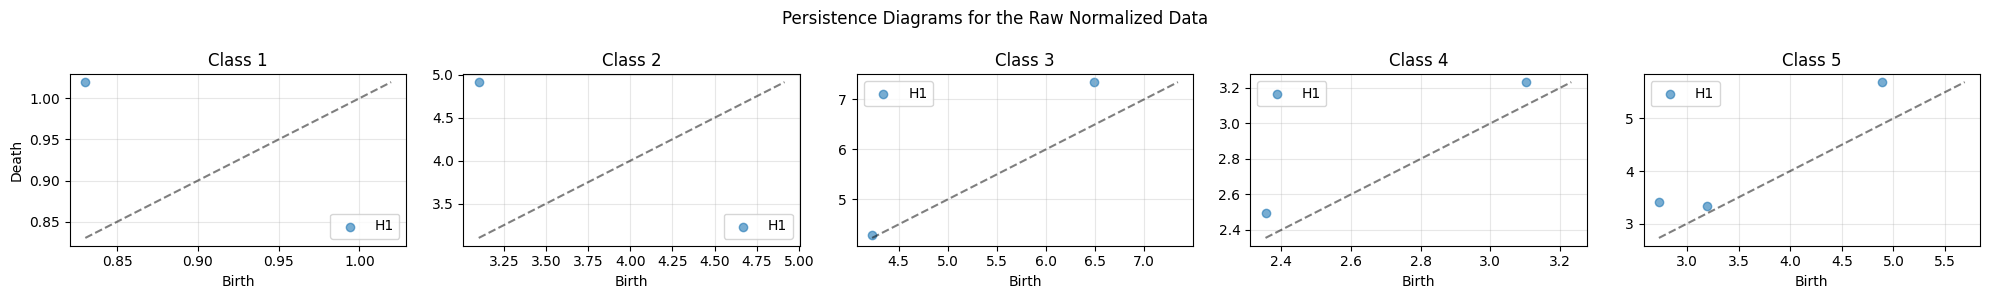

In [46]:
df_train = data.copy()
df_train[predictors] = normalize_data(df_train, predictors)

labels, persistence_images_normalized = get_tda_features_and_labels(df_train)
plot_persistence_images(labels, persistence_images_normalized, "normalized_data", samples_per_class=5)
plot_persistence_diagrams_from_data(df_train, "raw_normalized_data")

### 🛠 Data Splitting and Model Training Utilities

- `get_train_test_data(X, y, test_size=0.2, random_state=42)`:  
  Splits data into stratified train (60%), validation (20%), and test (20%) sets.  
  Flattens 3D inputs to 2D if needed.

- `generate_classification_report(y_true, y_pred, classes)`:  
  Generates a classification report with named classes and zero division handling.

- `train_and_tune_model(model, X_train, y_train, X_val, y_val, param_grid, model_name, scoring='f1_weighted')`:  
  Performs hyperparameter tuning using GridSearchCV, saves best model and metrics, and returns evaluation results.

- `split_and_flatten_persistence_images(persistence_images, labels, test_size=0.2, val_size=0.25, random_state=42)`:  
  Splits 3D persistence image data into train/val/test sets, flattening images for model input.


In [47]:
def get_train_test_data(X, y, test_size=0.2, random_state=42):
    """
    Splits input data into train, validation, and test sets with stratified sampling.

    If X is 3D, it's flattened to 2D. The data is split into 60% train, 20% validation, and 20% test.

    Args:
        X (ndarray): Input features.
        y (ndarray): Target labels.
        test_size (float): Proportion for test split. Default is 0.2.
        random_state (int): Random seed for reproducibility. Default is 42.

    Returns:
        Tuple of train, validation, and test splits: (X_train, X_val, X_test, y_train, y_val, y_test)
    """
    if X.ndim == 3:
        X = X.reshape(X.shape[0], -1)

    print(f"y.shape: {y.shape}")
    print(f"X.shape: {X.shape}")

    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)
    print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")

    return X_train, X_val, X_test, y_train, y_val, y_test


def generate_classification_report(y_true, y_pred, classes):
    report = classification_report(y_true, y_pred, zero_division=1, target_names=classes)
    return report


def train_and_tune_model(model, X_train, y_train, X_val, y_val, param_grid, model_name,scoring='f1_weighted'):
    os.makedirs('metrics', exist_ok=True)
    os.makedirs('models', exist_ok=True)

    grid_search = GridSearchCV(model, param_grid, cv=3, scoring=scoring, n_jobs=-1, return_train_score=True, verbose=1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    model_path = f"models/{model_name}_best_model.pkl"
    joblib.dump(best_model, model_path)

    y_val_pred = best_model.predict(X_val)

    metrics = {
        "model": model_name,
        "best_params": grid_search.best_params_, 
        "f1_score": f1_score(y_val, y_val_pred, average='weighted'),
        "accuracy" : accuracy_score(y_val, y_val_pred),
        "precision" : precision_score(y_val, y_val_pred, average='weighted'),
        "recall" : recall_score(y_val, y_val_pred, average='weighted'),
    }

    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df.to_csv(f"metrics/{model_name}_grid_search_results.csv", index=False)

    metrics_df = pd.DataFrame([metrics])
    metrics_summary_path = f"metrics/{model_name}_metrics_summary.csv"
    metrics_df.to_csv(metrics_summary_path, index=False)

    return best_model, metrics

def split_and_flatten_persistence_images(persistence_images, labels, test_size=0.2, val_size=0.25, random_state=42):
    """
    Splits and flattens persistence images into train, validation, and test sets.

    Parameters:
    - persistence_images (np.array): 3D array (samples, height, width) of persistence images.
    - labels (array-like): Corresponding labels.
    - test_size (float): Proportion of total data for test set.
    - val_size (float): Proportion of remaining data (after test split) for validation.
    - random_state (int): Random seed for reproducibility.

    Returns:
    - X_train, X_val, X_test, y_train, y_val, y_test: Flattened image arrays and labels.
    """
    X = np.array(persistence_images)
    y = np.array(labels)

    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_size, random_state=random_state)

    X_train = X_train.reshape(X_train.shape[0], -1)
    X_val = X_val.reshape(X_val.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    return X_train, X_val, X_test, y_train, y_val, y_test

### 🧪 Model Training and Evaluation on TDA Features

This section defines a streamlined pipeline for training and evaluating machine learning models on **Topological Data Analysis (TDA)** features extracted from the dataset.

- **`run_model_on_features`**  
  Runs the full pipeline:
  - Extracts TDA features and labels.
  - Splits the dataset into train/validation/test sets.
  - Trains the model using the provided training function.
  - Evaluates the model on the test set.
  - Displays a classification report and confusion matrix.

- **`run_knn_classifier`**  
  Trains a **K-Nearest Neighbors (KNN)** classifier using `GridSearchCV` for hyperparameter tuning (`n_neighbors`, `weights`).

- **`run_random_forest_classifier`**  
  Trains a **Random Forest** classifier using `GridSearchCV` to tune parameters like `n_estimators`, `max_depth`, and `min_samples_split`.

- **`plot_confusion_matrix`**  
  Visualizes a heatmap of the confusion matrix showing true vs. predicted class labels.

This framework enables fast experimentation with different classifiers on TDA-derived features and provides visual feedback for model performance.

In [48]:
def run_model_on_features(data, model_name, run_model_fn):
    """
    Args:
        data (DataFrame): The input dataset.
        model_name (str): Name of the model (for display/plotting purposes).
        run_model_fn (function): A function that trains the model.
        feature_func (function): A function that returns (y, X) from the data.
    """
    print(f"\n=== {model_name}s ===")
    
    y, X = get_tda_features_and_labels(data)
    X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_data(X, y)
    
    best_model, metrics = run_model_fn(X_train, y_train, X_val, y_val, model_name)
    
    y_test_pred = best_model.predict(X_test)
    classes = [str(c) for c in np.unique(y_test)]
    
    print("\nTest Results:")
    print(generate_classification_report(y_test, y_test_pred, classes))
    plot_confusion_matrix(y_test, y_test_pred, classes, f"{model_name} Test Confusion Matrix")


def run_knn_classifier(X_train, y_train, X_val, y_val, model_name="KNN"):
    param_grid = {
        "n_neighbors": [3, 5, 7],
        "weights": ["uniform", "distance"]
    }

    best_model, metrics = train_and_tune_model(
        KNeighborsClassifier(), X_train, y_train, X_val, y_val, param_grid, model_name
    )
    return best_model, metrics


def run_random_forest_classifier(X_train, y_train, X_val, y_val, model_name="Random Forest"):
    """
    Trains and tunes a RandomForestClassifier using GridSearchCV.
    Returns the best model and validation metrics.
    """
    param_grid = {
        "n_estimators": [100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5]
    }

    best_model, metrics = train_and_tune_model(
        RandomForestClassifier(), X_train, y_train, X_val, y_val, param_grid, model_name
    )
    return best_model, metrics


def plot_confusion_matrix(y_true, y_pred, classes, title):
    confusion_mat = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Model predictions")
    plt.ylabel("True labels")
    plt.show()


=== KNN Classifiers ===
y.shape: (11500,)
X.shape: (11500, 100)
Train shape: (6900, 100), Validation shape: (2300, 100), Test shape: (2300, 100)
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Test Results:
              precision    recall  f1-score   support

           1       1.00      0.90      0.95       455
           2       0.81      1.00      0.90       455
           3       1.00      0.94      0.97       465
           4       1.00      0.99      1.00       456
           5       1.00      0.94      0.97       469

    accuracy                           0.95      2300
   macro avg       0.96      0.95      0.96      2300
weighted avg       0.96      0.95      0.96      2300



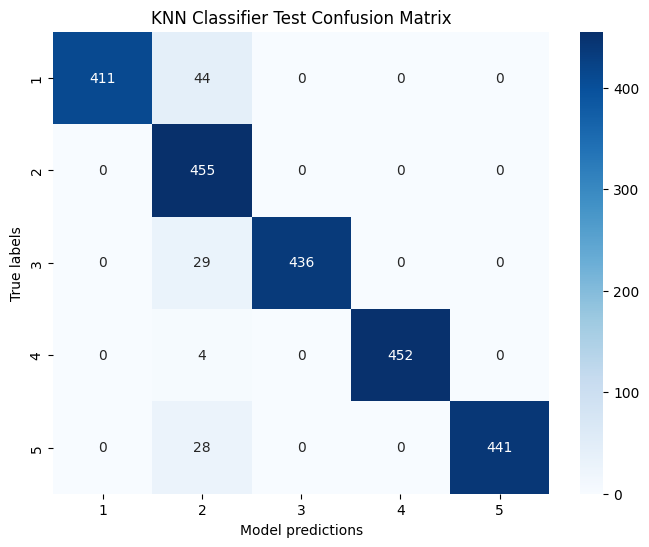

In [49]:
run_model_on_features(df_train, "KNN Classifier", run_knn_classifier)


=== Random Forest Classifiers ===
y.shape: (11500,)
X.shape: (11500, 100)
Train shape: (6900, 100), Validation shape: (2300, 100), Test shape: (2300, 100)
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Test Results:
              precision    recall  f1-score   support

           1       1.00      0.90      0.95       455
           2       0.81      1.00      0.90       455
           3       1.00      0.94      0.97       465
           4       1.00      0.99      1.00       456
           5       1.00      0.94      0.97       469

    accuracy                           0.95      2300
   macro avg       0.96      0.95      0.96      2300
weighted avg       0.96      0.95      0.96      2300



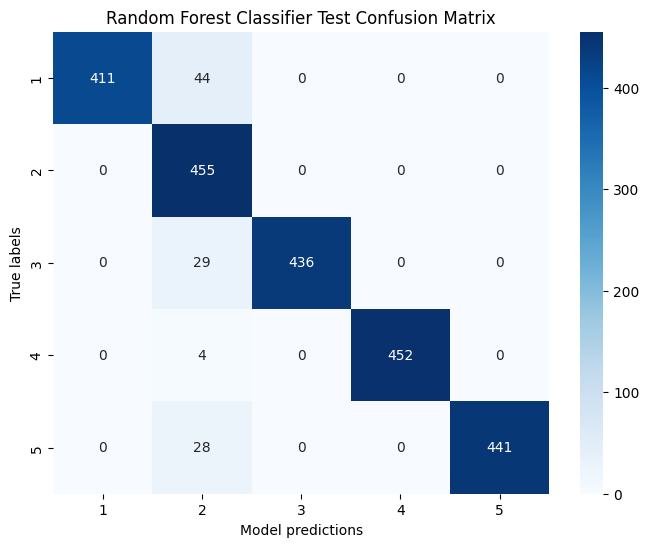

In [50]:
run_model_on_features(df_train, "Random Forest Classifier", run_random_forest_classifier)

### `gaussian_noise`

Adds Gaussian (normal) noise to input data to simulate sensor or environmental noise.  
Useful for testing model robustness.

**Parameters:**
- `x`: Input data (array-like)
- `percentage`: Noise level as a fraction of standard deviation (default: 0.01)

**Returns:**  
Noisy version of the input data.

### `artifact_noise`

Injects synthetic artifacts into EEG signals to simulate real-world noise.

**Parameters:**
- `x`: 1D EEG signal (array-like)
- `artifact_type`: Type of artifact to add (`'spike'`, `'eyeblink'`)
- `percentage`: Proportion of the signal to affect (default: 0.01)
- `fs`: Sampling frequency, used for time-based artifacts (default: 250 Hz)

**Returns:**  
EEG signal with added artifacts (e.g., spikes or eyeblinks).


In [52]:

def gaussian_noise(x, percentage=0.01):
    col_std = x.std()
    noise = np.random.normal(0, col_std, size=len(x)) * percentage

    x_noisy = x + noise

    return x_noisy 

def artifact_noise(x, artifact_type, percentage=0.01, fs=250):
    x_artifact = np.array(x, dtype=float).copy()
    n = len(x)
    
    # Number of artifact events (not raw points) for segment-based artifacts
    n_artifacts = max(1, int(n * percentage))

    if artifact_type == 'spike':
        positions = np.random.choice(n, n_artifacts, replace=False)
        spike_magnitude = np.random.uniform(5, 10) * np.std(x)
        x_artifact[positions] += spike_magnitude


    elif artifact_type == 'eyeblink':
        duration = int(0.4 * fs)
        blink = np.exp(-np.linspace(0, 4, duration)**2)
        blink *= np.random.uniform(50, 100)  # amplitude
        for _ in range(n_artifacts):
            start = np.random.randint(0, n - duration)
            x_artifact[start:start+duration] += blink

    else:
        raise ValueError(f"Unknown artifact type: {artifact_type}")
    
    return x_artifact

## Pipeline with Gaussian Noise added

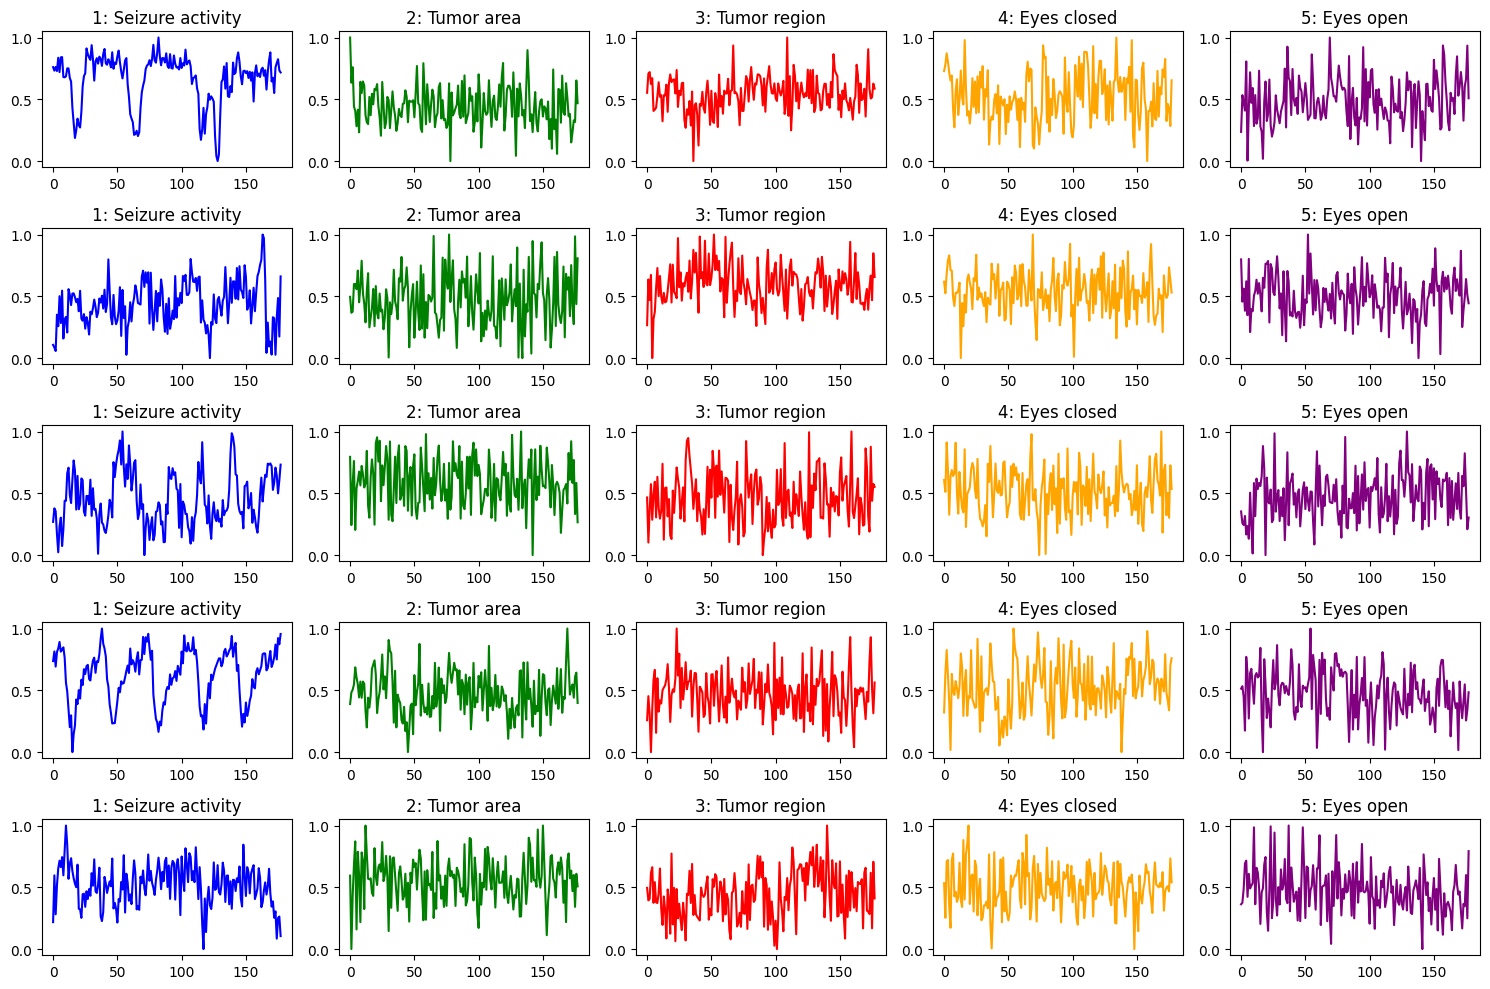

In [53]:
df_viz_gaussian = data.copy()
feature_cols = [x for x in data.columns if x.startswith('X')]
df_viz_gaussian[feature_cols] = df_viz_gaussian[feature_cols].apply(gaussian_noise, percentage=1)
df_viz_gaussian['y'] = df_viz_gaussian['y'].map(class_labels)
X_viz_gaussian = normalize_data(df_viz_gaussian, predictors)  
y_viz_gaussian, _ =  get_features_and_labels(data)  

plot_class_signals(X_viz_gaussian, y_viz_gaussian)

/var/folders/xy/03cjwd9527j8gnxjzhw31yjm0000gn/T/ipykernel_84535/1919744751.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_['subject_ids'] = ids.str.extract(r'(\d+$)')[0].astype(int)
/var/folders/xy/03cjwd9527j8gnxjzhw31yjm0000gn/T/ipykernel_84535/1919744751.py:95: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


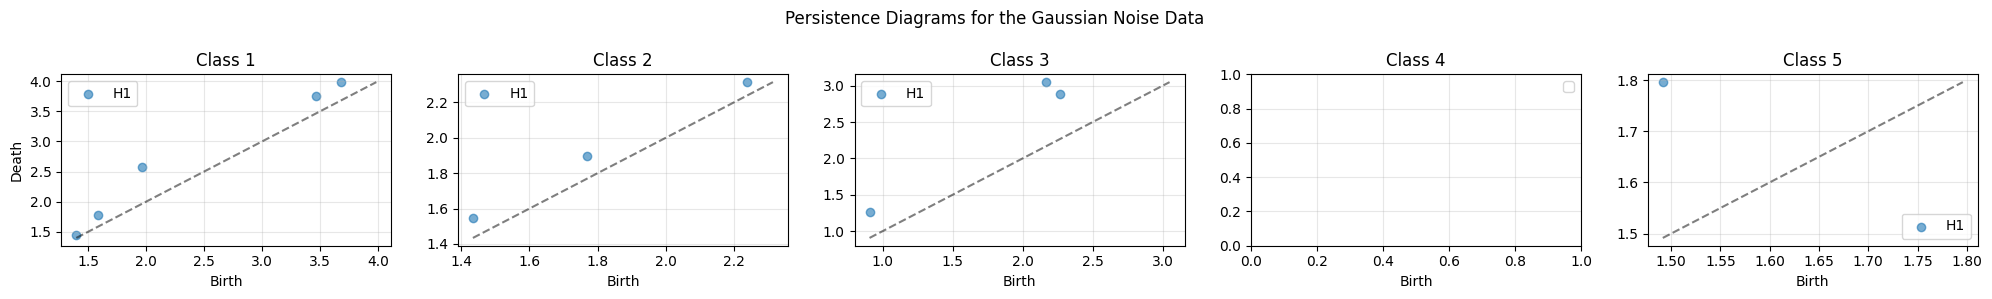

/var/folders/xy/03cjwd9527j8gnxjzhw31yjm0000gn/T/ipykernel_84535/1549172904.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_['second_ids'] = ids.str.extract(r'(\d+)')[0].astype(int)


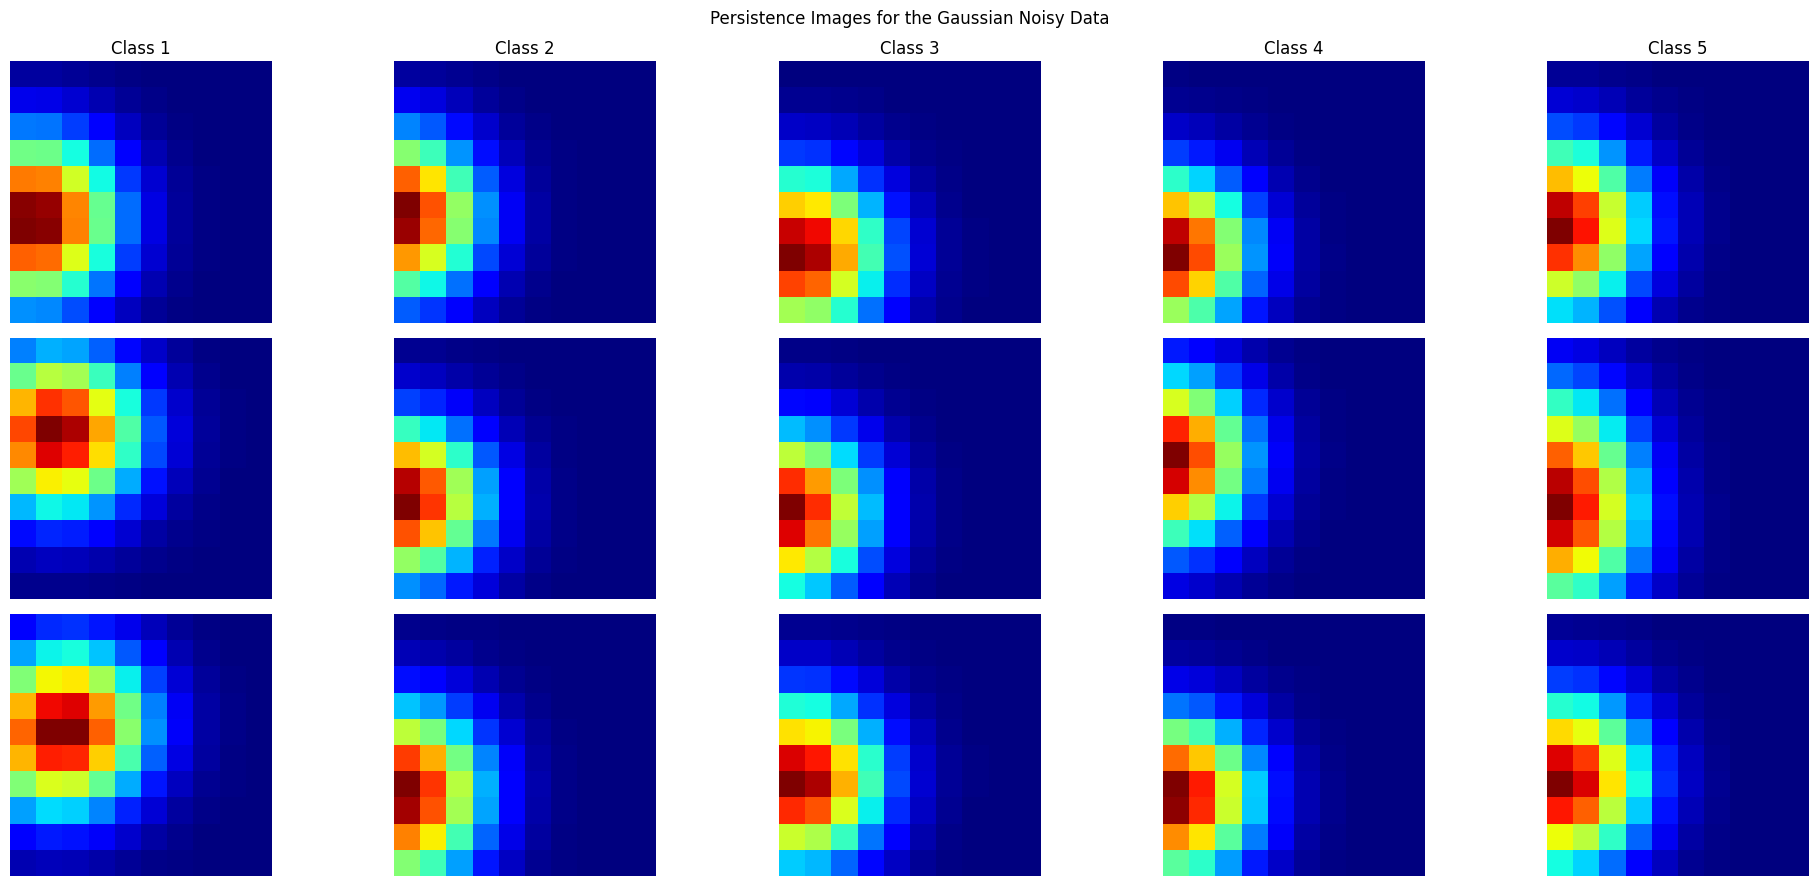

In [54]:
df_train_gaussian = data.copy()
feature_cols = [x for x in data.columns if x.startswith('X')]
df_train_gaussian[feature_cols] = df_train_gaussian[feature_cols].apply(gaussian_noise, percentage=1)
df_train_gaussian[predictors] = normalize_data(df_train_gaussian, predictors)

plot_persistence_diagrams_from_data(df_train_gaussian, "gaussian_noise_data")
labels, persistence_images_noisy = get_tda_features_and_labels(df_train_gaussian)
plot_persistence_images(labels, persistence_images_noisy, "gaussian noisy data")



=== KNN Classifiers ===
y.shape: (11500,)
X.shape: (11500, 100)
Train shape: (6900, 100), Validation shape: (2300, 100), Test shape: (2300, 100)
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Test Results:
              precision    recall  f1-score   support

           1       1.00      0.96      0.98       455
           2       0.80      1.00      0.89       455
           3       1.00      0.95      0.97       465
           4       1.00      0.91      0.96       456
           5       1.00      0.93      0.96       469

    accuracy                           0.95      2300
   macro avg       0.96      0.95      0.95      2300
weighted avg       0.96      0.95      0.95      2300



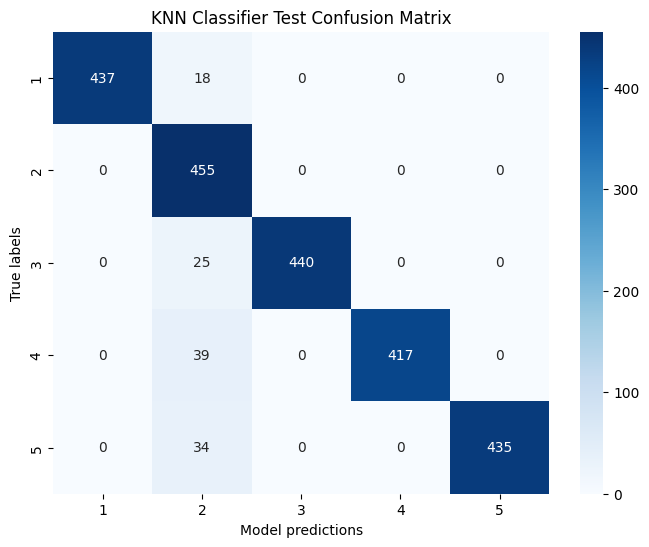

In [55]:
run_model_on_features(df_train_gaussian, "KNN Classifier", run_knn_classifier)


=== Random Forest Classifiers ===
y.shape: (11500,)
X.shape: (11500, 100)
Train shape: (6900, 100), Validation shape: (2300, 100), Test shape: (2300, 100)
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Test Results:
              precision    recall  f1-score   support

           1       1.00      0.96      0.98       455
           2       1.00      0.94      0.97       455
           3       1.00      0.95      0.97       465
           4       1.00      0.91      0.96       456
           5       0.81      1.00      0.89       469

    accuracy                           0.95      2300
   macro avg       0.96      0.95      0.95      2300
weighted avg       0.96      0.95      0.95      2300



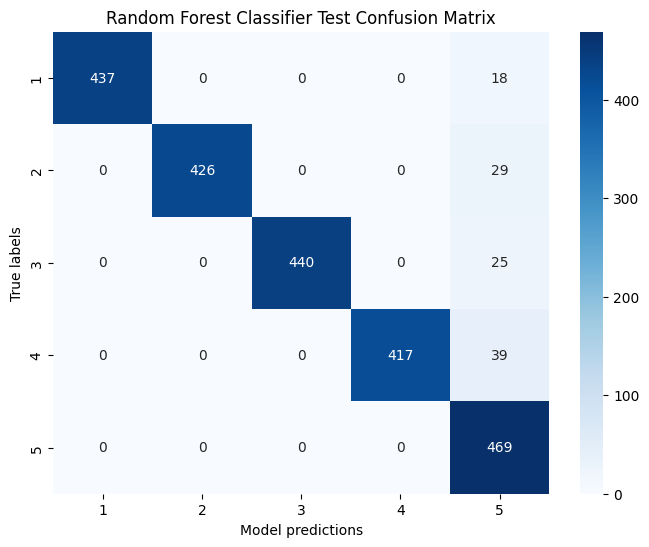

In [56]:
run_model_on_features(df_train_gaussian, "Random Forest Classifier", run_random_forest_classifier)

## Pipeline with Spike Noise added

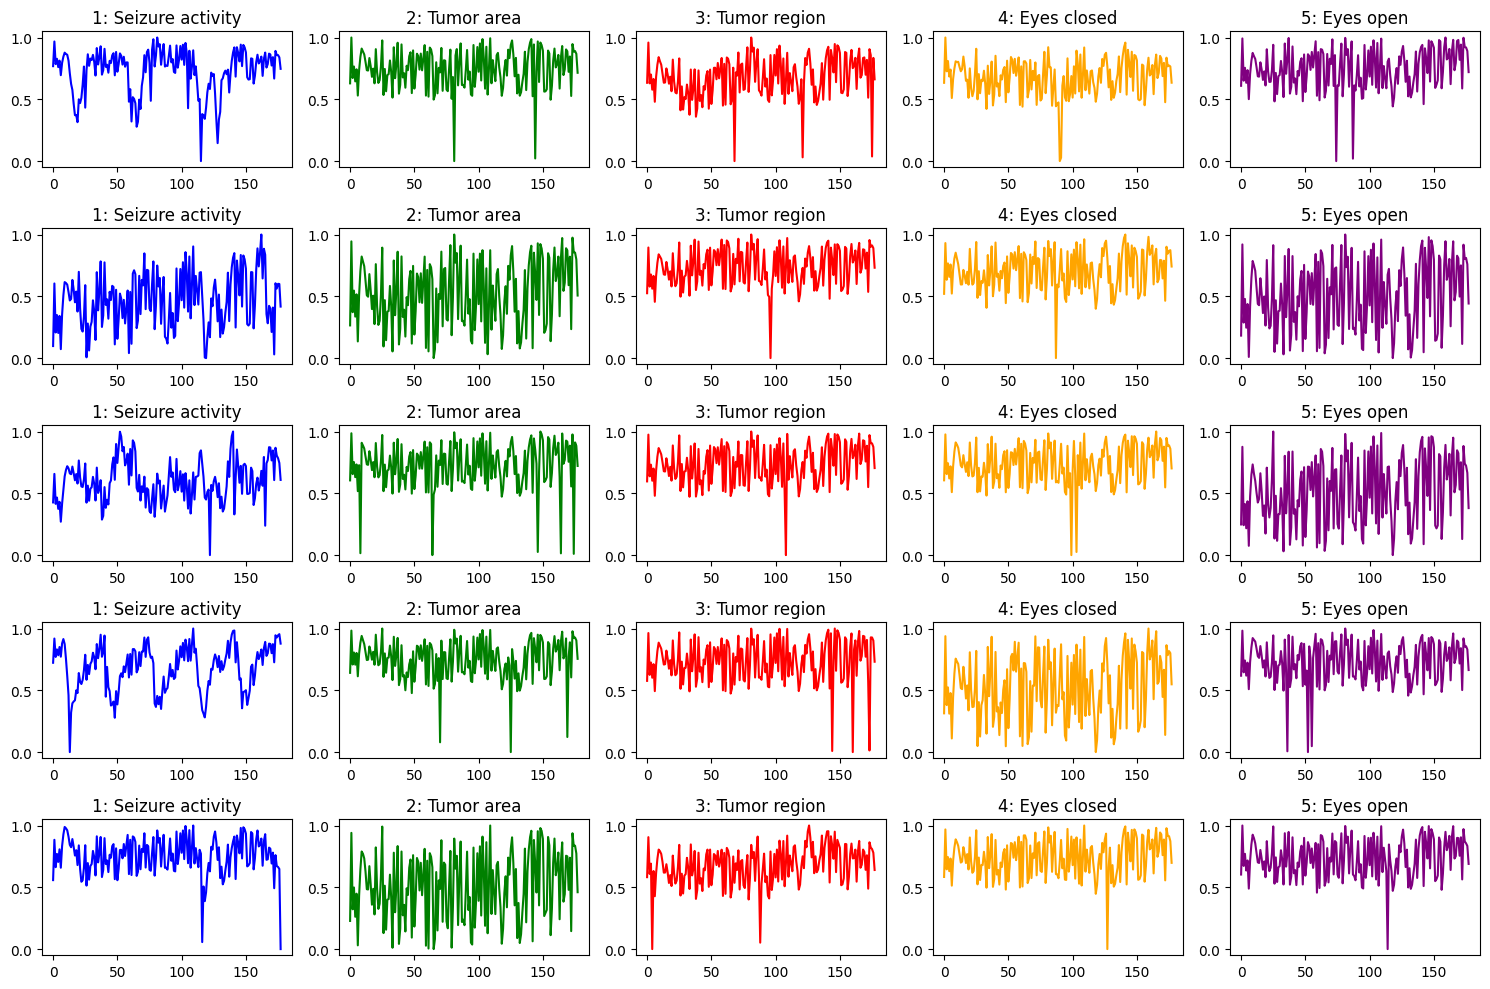

In [57]:
df_viz_spike = data.copy()
feature_cols = [x for x in data.columns if x.startswith('X')]

for i, col in enumerate(feature_cols):
    artifact_type = 'spike'
    df_viz_spike[col] = artifact_noise(df_viz_spike[col], 
                                   artifact_type=artifact_type,
                                   percentage=0.99)  
df_viz_spike['y'] = df_viz_spike['y'].map(class_labels) 
X_viz_spike = normalize_data(df_viz_spike, predictors)
y_viz_spike, _ =  get_features_and_labels(data)  

plot_class_signals(X_viz_spike, y_viz_spike)

In [58]:
df_train_spike = data.copy()
feature_cols = [x for x in data.columns if x.startswith('X')]

# Add different types of artifacts to different columns
for i, col in enumerate(feature_cols):
    artifact_type = 'spike'
    df_train_spike[col] = artifact_noise(df_train_spike[col], 
                                   artifact_type='spike',
                                   percentage=0.99)  # 99% of points affected

df_train_spike[feature_cols] = normalize_data(df_train_spike, feature_cols)

/var/folders/xy/03cjwd9527j8gnxjzhw31yjm0000gn/T/ipykernel_84535/1919744751.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_['subject_ids'] = ids.str.extract(r'(\d+$)')[0].astype(int)


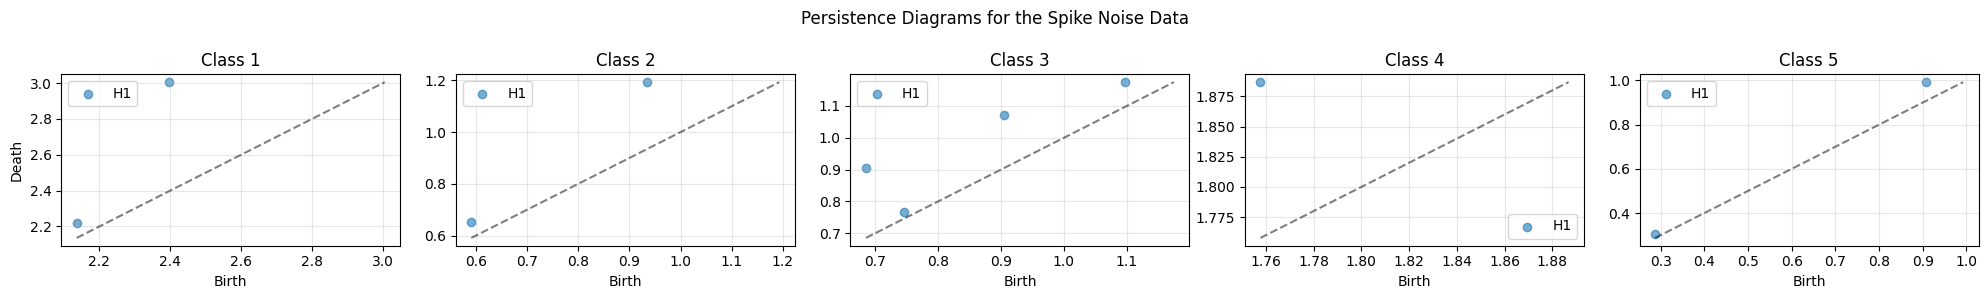

/var/folders/xy/03cjwd9527j8gnxjzhw31yjm0000gn/T/ipykernel_84535/1549172904.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_['second_ids'] = ids.str.extract(r'(\d+)')[0].astype(int)


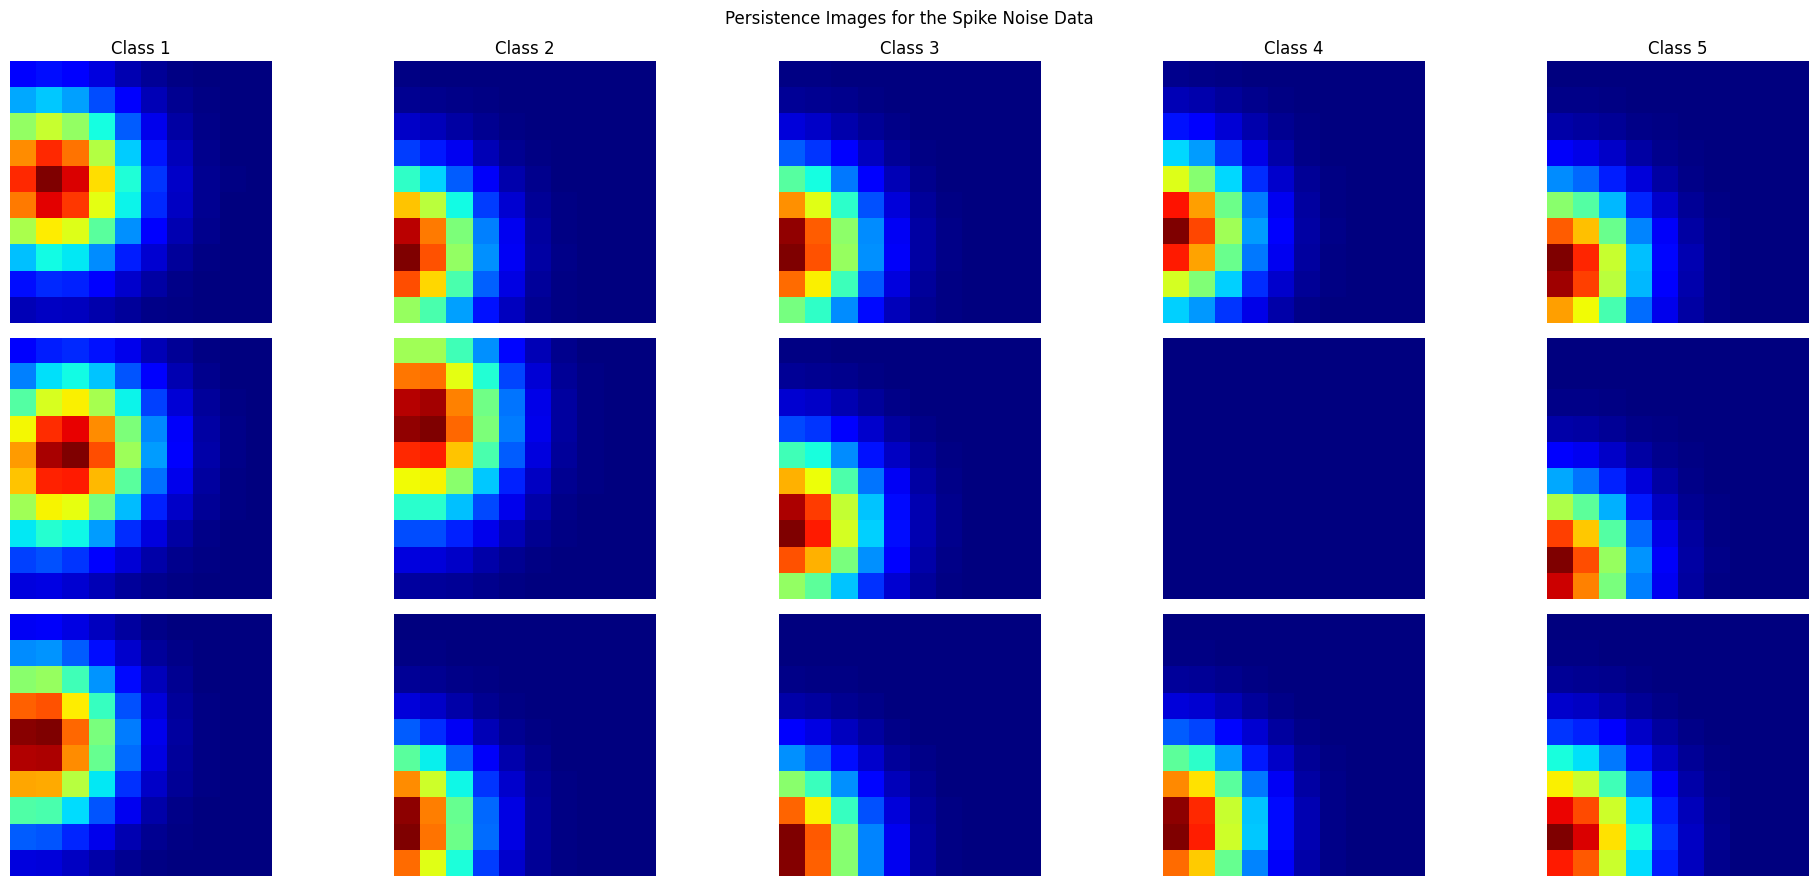

In [59]:
plot_persistence_diagrams_from_data(df_train_spike, "spike_noise_data")
labels, persistence_images_noisy = get_tda_features_and_labels(df_train_spike)
plot_persistence_images(labels, persistence_images_noisy, "spike_noise_data")


=== KNN Classifiers ===
y.shape: (11500,)
X.shape: (11500, 100)
Train shape: (6900, 100), Validation shape: (2300, 100), Test shape: (2300, 100)
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Test Results:
              precision    recall  f1-score   support

           1       0.72      1.00      0.84       455
           2       1.00      0.85      0.92       455
           3       1.00      0.93      0.96       465
           4       1.00      0.91      0.95       456
           5       1.00      0.91      0.96       469

    accuracy                           0.92      2300
   macro avg       0.94      0.92      0.93      2300
weighted avg       0.94      0.92      0.93      2300



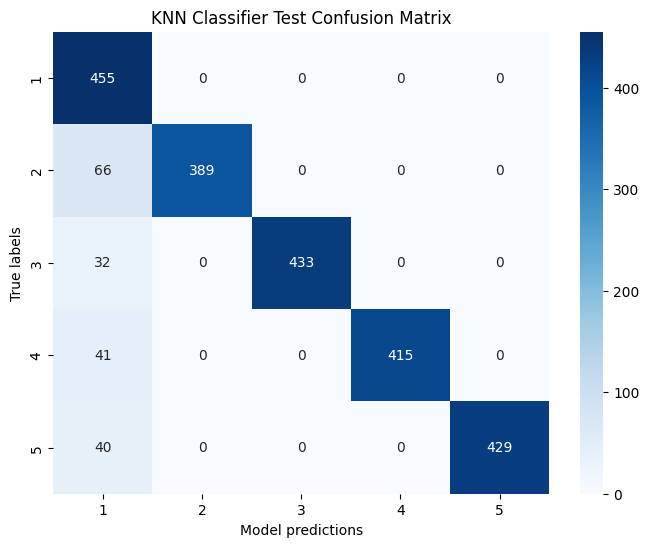

In [60]:
run_model_on_features(df_train_spike, "KNN Classifier", run_knn_classifier)


=== Random Forest Classifiers ===
y.shape: (11500,)
X.shape: (11500, 100)
Train shape: (6900, 100), Validation shape: (2300, 100), Test shape: (2300, 100)
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Test Results:
              precision    recall  f1-score   support

           1       1.00      0.85      0.92       455
           2       0.72      1.00      0.83       455
           3       1.00      0.93      0.96       465
           4       1.00      0.91      0.95       456
           5       1.00      0.91      0.96       469

    accuracy                           0.92      2300
   macro avg       0.94      0.92      0.93      2300
weighted avg       0.94      0.92      0.93      2300



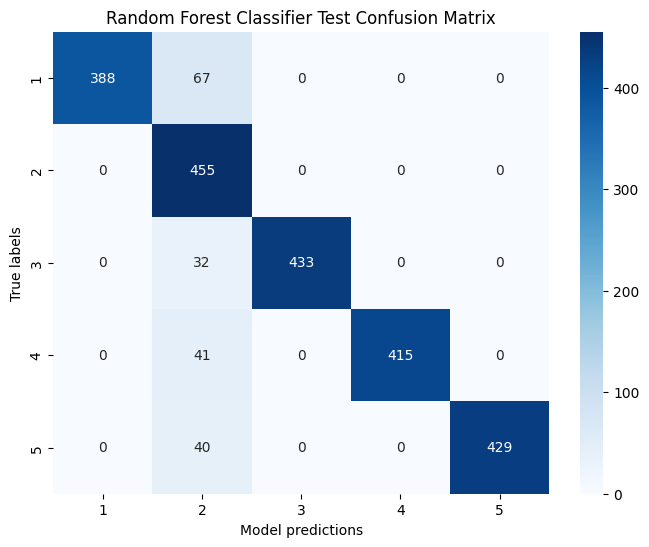

In [61]:
run_model_on_features(df_train_spike, "Random Forest Classifier", run_random_forest_classifier)

## Pipeline with Eyeblink Noise added

In [62]:
df_viz_eyeblink = data.copy()
feature_cols = [x for x in df_viz_eyeblink.columns if x.startswith('X')]

for i, col in enumerate(feature_cols):
    artifact_type = 'eyeblink'
    df_viz_eyeblink[col] = artifact_noise(df_viz_eyeblink[col], 
                                   artifact_type=artifact_type,
                                   percentage=0.1)  
df_viz_eyeblink['y'] = df_viz_eyeblink['y'].map(class_labels) 
X_viz_eyeblink = normalize_data(df_viz_eyeblink, predictors)
y_viz_eyeblink, _ =  get_features_and_labels(df_viz_eyeblink)  

In [63]:
df_train_eyeblink = data.copy()
df_train_eyeblink['Unnamed'] = data['Unnamed']  # if needed

feature_cols = [x for x in df_train_eyeblink.columns if x.startswith('X')]

for col in feature_cols:
    df_train_eyeblink[col] = artifact_noise(df_train_eyeblink[col], artifact_type='eyeblink', percentage=0.99)

df_train_eyeblink[feature_cols] = normalize_data(df_train_eyeblink, feature_cols)

/var/folders/xy/03cjwd9527j8gnxjzhw31yjm0000gn/T/ipykernel_84535/1919744751.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_['subject_ids'] = ids.str.extract(r'(\d+$)')[0].astype(int)


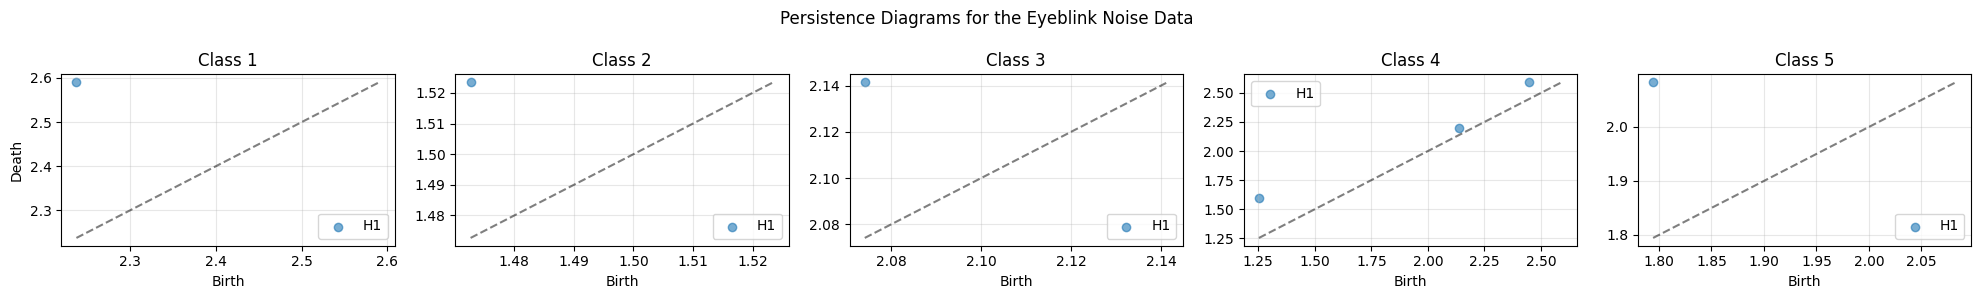

/var/folders/xy/03cjwd9527j8gnxjzhw31yjm0000gn/T/ipykernel_84535/1549172904.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_['second_ids'] = ids.str.extract(r'(\d+)')[0].astype(int)


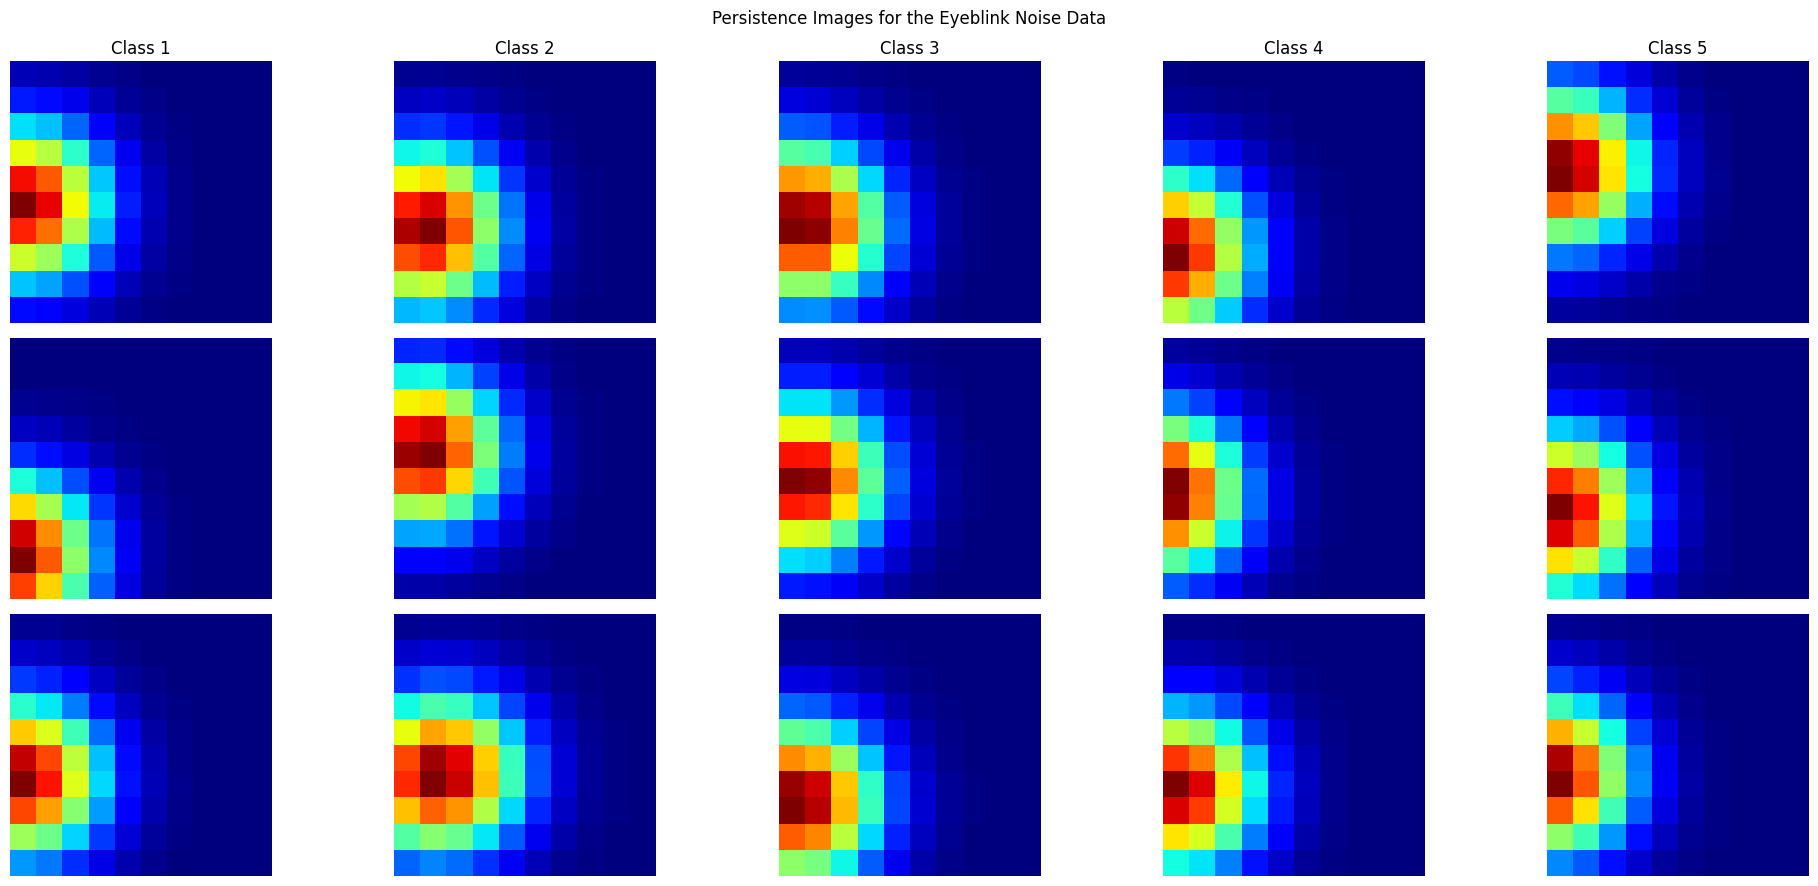

In [64]:
plot_persistence_diagrams_from_data(df_train_eyeblink, "eyeblink_noise_data")
labels, persistence_images_noisy = get_tda_features_and_labels(df_train_eyeblink)
plot_persistence_images(labels, persistence_images_noisy, "eyeblink_noise_data")


=== KNN Classifiers ===
y.shape: (11500,)
X.shape: (11500, 100)
Train shape: (6900, 100), Validation shape: (2300, 100), Test shape: (2300, 100)
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Test Results:
              precision    recall  f1-score   support

           1       0.75      1.00      0.86       455
           2       1.00      0.90      0.95       455
           3       1.00      0.92      0.96       465
           4       1.00      0.92      0.96       456
           5       1.00      0.94      0.97       469

    accuracy                           0.94      2300
   macro avg       0.95      0.94      0.94      2300
weighted avg       0.95      0.94      0.94      2300



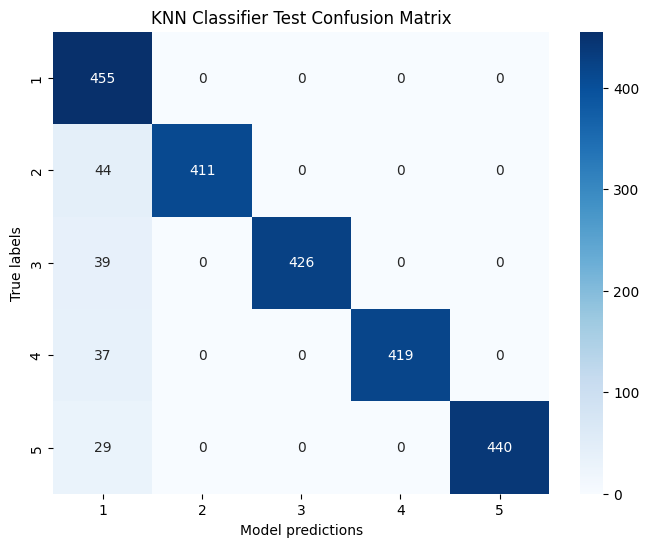

In [65]:
run_model_on_features(df_train_eyeblink, "KNN Classifier", run_knn_classifier)


=== Random Forest Classifiers ===
y.shape: (11500,)
X.shape: (11500, 100)
Train shape: (6900, 100), Validation shape: (2300, 100), Test shape: (2300, 100)
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Test Results:
              precision    recall  f1-score   support

           1       1.00      0.92      0.96       455
           2       0.76      1.00      0.86       455
           3       1.00      0.92      0.96       465
           4       1.00      0.92      0.96       456
           5       1.00      0.94      0.97       469

    accuracy                           0.94      2300
   macro avg       0.95      0.94      0.94      2300
weighted avg       0.95      0.94      0.94      2300



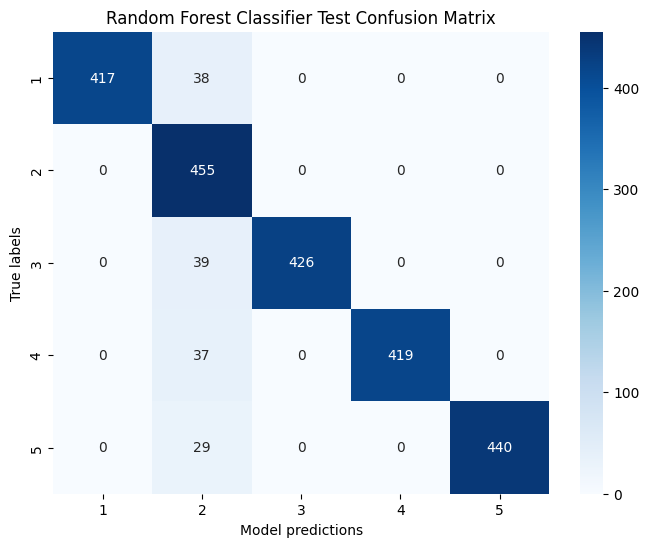

In [66]:
run_model_on_features(df_train_eyeblink, "Random Forest Classifier", run_random_forest_classifier)